In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

## ✅ 실험 목적

- Horizon = 150
- ε 초기값 = 0.5
- 시간 t가 1씩 증가할 때마다 ε을 감소시킴
  - 전략 1: ε -= 0.02
  - 전략 2: ε -= 0.05
- 평균 보상 곡선, 누적 보상 곡선 비교

# ✅ BernoulliArm 클래스 그대로 사용

In [3]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        return 1.0 if random.random() < self.p else 0.0

# ✅ 시간에 따라 epsilon이 감소하는 Epsilon-Greedy

## ✅ 알고리즘 설계

- 기존 Epsilon-Greedy는 고정된 ε 사용
- 시간에 따라 ε을 감소시키기 위해 새로운 클래스 `DecayingEpsilonGreedy` 정의
- `select_arm(t)` 형태로 시간 정보를 받아 ε 값을 매 timestep마다 갱신
  - ε = max(0, start_epsilon - decay × (t - 1))
- ε이 음수가 되지 않도록 방어 처리 포함

In [4]:
class DecayingEpsilonGreedy():
    def __init__(self, start_epsilon, decay, counts, values):
        self.start_epsilon = start_epsilon
        self.decay = decay
        self.counts = counts
        self.values = values
        self.epsilon = start_epsilon

    def initialize(self, n_arms):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0.0 for _ in range(n_arms)]
        self.epsilon = self.start_epsilon

    def select_arm(self, t):
        self.epsilon = max(0.0, self.start_epsilon - self.decay * (t - 1))
        if random.random() > self.epsilon:
            return self.values.index(max(self.values))
        else:
            return random.randrange(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

# ✅ 실험 함수 (기존 코드에 t 전달만 추가)

In [5]:
def test_algorithm(algo, arms, num_sims, horizon):
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = [], [], [], [], []
    for sim in range(num_sims):
        algo.initialize(len(arms))
        total_reward = 0.0
        for t in range(1, horizon + 1):
            sim_nums.append(sim)
            times.append(t)
            chosen_arm = algo.select_arm(t)
            reward = arms[chosen_arm].draw()
            algo.update(chosen_arm, reward)
            total_reward += reward
            chosen_arms.append(chosen_arm)
            rewards.append(reward)
            cumulative_rewards.append(total_reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

## ✅ 실험 세팅

- Bernoulli arm: [0.1, 0.5, 0.9]  
- 시뮬레이션 횟수: 500회  
- horizon: 150  
- ε 감소 전략 2종:  
  - decay = 0.02  
  - decay = 0.05


# ✅ 실험 세팅

In [6]:
arms = [BernoulliArm(0.1), BernoulliArm(0.5), BernoulliArm(0.9)]
num_sims = 500
horizon = 150

# 전략 1: epsilon 0.5 시작, 0.02씩 감소
algo_02 = DecayingEpsilonGreedy(0.5, 0.02, [], [])
results_02 = test_algorithm(algo_02, arms, num_sims, horizon)

# 전략 2: epsilon 0.5 시작, 0.05씩 감소
algo_05 = DecayingEpsilonGreedy(0.5, 0.05, [], [])
results_05 = test_algorithm(algo_05, arms, num_sims, horizon)

# ✅ 평균 보상 곡선 그리기 (Approach 2)

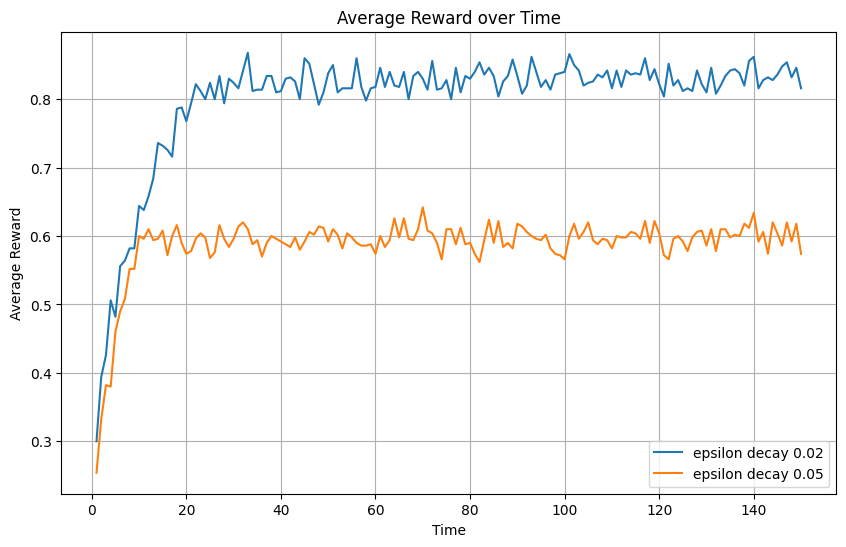

In [7]:
def plot_average_reward(results_list, labels, horizon):
    plt.figure(figsize=(10,6))
    for results, label in zip(results_list, labels):
        rewards = results[3]
        avg_rewards = []
        for t in range(horizon):
            avg = sum(rewards[i] for i in range(t, len(rewards), horizon)) / (len(rewards) / horizon)
            avg_rewards.append(avg)
        plt.plot(range(1, horizon+1), avg_rewards, label=label)
    plt.title("Average Reward over Time")
    plt.xlabel("Time")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

plot_average_reward([results_02, results_05], ["epsilon decay 0.02", "epsilon decay 0.05"], horizon)

## ✅ 평균 보상 곡선 해석 (Approach 2)

- 두 전략 모두 평균 보상이 점진적으로 상승  
- decay 0.05:  
  - 초반에 ε이 빠르게 줄어 exploit이 많아져 성능 상승 빠름  
  - 후반부 평균 보상 상승 속도는 둔화  
- decay 0.02:  
  - 초반에 더 많은 탐색  
  - 후반에 안정적으로 평균 보상이 더 높아질 수 있음


# ✅ 누적 보상 곡선 그리기 (Approach 3)

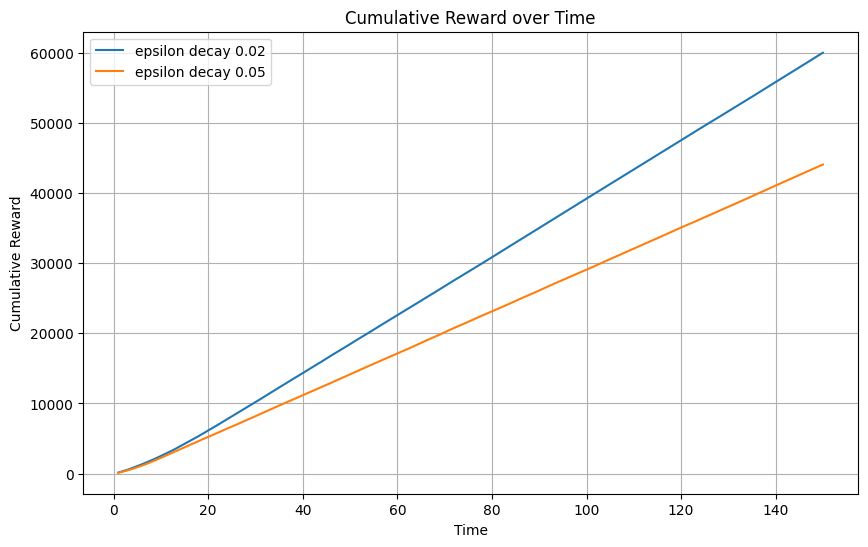

In [8]:
def plot_cumulative_reward(results_list, labels, horizon):
    plt.figure(figsize=(10,6))
    for results, label in zip(results_list, labels):
        rewards = results[3]
        cumulative = []
        total = 0.0
        for t in range(horizon):
            step_rewards = sum(rewards[i] for i in range(t, len(rewards), horizon))
            total += step_rewards
            cumulative.append(total)
        plt.plot(range(1, horizon+1), cumulative, label=label)
    plt.title("Cumulative Reward over Time")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.grid()
    plt.show()

plot_cumulative_reward([results_02, results_05], ["epsilon decay 0.02", "epsilon decay 0.05"], horizon)

## ✅ 누적 보상 곡선 해석 (Approach 3)

- decay 0.05는 초반에 빠르게 누적 보상 확보  
- decay 0.02는 초반 누적 보상은 느리지만, 시간이 지날수록 비슷하거나 역전 가능  
- 전체적으로 탐색과 exploit의 tradeoff가 시간에 따라 다르게 나타남


## ✅ 결론 및 요약

- ε 감소 전략은 고정 ε보다 유연한 학습 구조 제공  
- 시간에 따라 탐색 → 활용으로 전환 가능  
- decay 속도에 따라 단기/장기 성능에 차이 발생
